In [1]:
import numpy as np
import matplotlib.pyplot as plt
import mogli
import os
from ipywidgets import IntProgress
from IPython.display import display, clear_output
from PIL import Image

from src.CameraPoseVisualizer import CameraPoseVisualizer

import importlib


In [2]:
bandgaps = np.loadtxt('Datasets/bandgaps.csv')
cods = np.loadtxt('Datasets/CODids.csv', dtype=int)
materials = mogli.read('Datasets/structures.xyz')

In [3]:
def circle(radius, n):
    theta = np.linspace(0, 2*np.pi, n)
    x = radius*np.cos(theta)
    y = radius*np.sin(theta)
    z = np.zeros_like(theta)
    # put x,y, and z as columns in a matrix
    
    return np.column_stack((x.flatten(),y.flatten(),z.flatten()))
# x = circle(100, 20)

# plt.figure(figsize=(10,10))
# plt.plot(x[:,0], x[:,1], 'o')

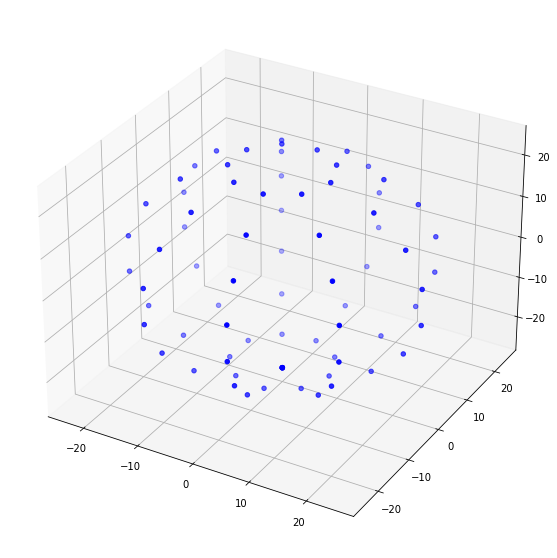

In [4]:
def sphere (radius, n):
    theta = np.linspace(0, 2*np.pi, n)
    phi = np.linspace(0, np.pi, n)
    x = radius*np.outer(np.cos(theta), np.sin(phi)).flatten()
    y = radius*np.outer(np.sin(theta), np.sin(phi)).flatten()
    z = radius*np.outer(np.ones(np.size(theta)), np.cos(phi)).flatten()
    
    
    mask = np.logical_and(x != 0, y != 0)
    x = x[mask]
    y = y[mask]
    z = z[mask]
    
    # print(x.shape)
    
    return np.column_stack((x,y,z))
s = sphere(25, 10)
# plot points
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111, projection='3d')

ax.scatter(s[:,0], s[:,1], s[:,2], c='b', marker='o')

In [5]:
import numpy as np
def normalize (v):
    return v/np.linalg.norm(v)
def create_camera_matrix(camera_position, point_of_view, up_vector):
    Z  = normalize(camera_position- point_of_view)
    X = normalize(np.cross(up_vector, Z))
    Y = np.cross(Z, X)
    m = np.identity(4)
    m[:3,0] = X
    m[:3,1] = Y
    m[:3,2] = Z
    m[:3,3] = camera_position
    return m

In [6]:
def calculate_focal_length(verticalFieldOfView):
    return 1/np.tan(np.radians(verticalFieldOfView))
calculate_focal_length(45)



1.0000000000000002

initialize camera pose visualizer


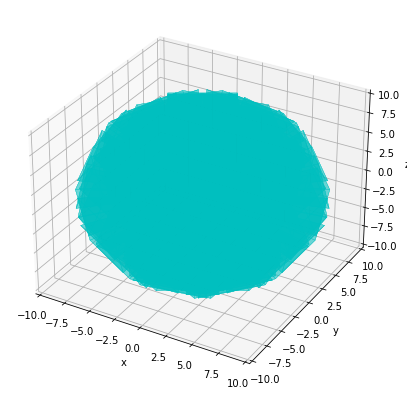

In [14]:
bonds_param = 1.51
width = 100
height = 100
distance = 10
formatFile = "jpg"
Y_levels = 10
circle_points = 10
Y_step = 10 
importlib.reload(mogli)
path = f'Datasets/3d/{width}x{height}_BP{bonds_param}/'
if not os.path.exists(path):
    os.makedirs(path)    
for i, molecule in enumerate(materials):
    pathmolecule = f'{path}/{i}'
    if not os.path.exists(pathmolecule):
        os.makedirs(pathmolecule)   
    # Nerf = NerfData()
    data  = {}
    sp = sphere(distance, 10)
    
    data["poses"] = np.zeros((sp.shape[0],4,4),dtype=np.float32)
    data["images"] = np.zeros((sp.shape[0],width,height,3 if formatFile == "jpg" else 4),dtype=np.float32)
    data["focal"] = np.array(1,dtype=np.float32)
    # sp = sphere(distance, 10)
    
    for n , (x,y,z) in enumerate(sp):
        # if x == 0 and y == 0:
        #     continue            
        img_path = f"{pathmolecule}/molecula_x_{i}_{n}_{x}_{y}_{z}.{formatFile}"
        camera = mogli.export(molecule,img_path,bonds_param=bonds_param,camera=((x,y,z),(0, 0, 0),(0 , 0 , 1)), width=width, height=height)            
        # print(camera)
        # break 
        img =  Image.open(img_path)
        
        # img = np.array(img, dtype=np.float32) / 255.0
        # new_image = Image.new("RGB", img.size, (0, 0, 0))

# Paste the original image onto the new image
        # new_image.paste(img, (0, 0), img)
        # new_image.save(img_path)
        # camera = create_camera_matrix(np.array([x,y,z]), np.array([0, 0, 0]), np.array([0, 1, 0]))
        data["poses"][n] = camera.T
        data["images"][n] = np.array(img)/255.0
        
        # Nerf.frames.append(Cameraframe(f"./molecula_x_{i}_{n}_{x}_{y}_{z}.{formatFile}",camera))
    # Nerf.save(f"{pathmolecule}/nerf.json")

    # print(jsonStr)
            
    visualizer = CameraPoseVisualizer([-10, 10], [-10, 10], [-10, 10])

    for pose in data["poses"]:
        visualizer.extrinsic2pyramid(pose, 'c', 10)
    # visualizer.show()   
    # clear_output(wait=True)    
    # ! python colmap2nerf.py --colmap_matcher exhaustive --run_colmap --aabb_scale 32 --images {pathmolecule} --out {pathmolecule}/nerfBueno.json --overwrite
    # break}
        
    np.savez(f"{pathmolecule}/data.npz", **data)
    break

In [8]:

def loadData(Path):
    x = np.load(Path, allow_pickle=True)
    print(x["images"].shape)
    print(x["poses"].shape)
    return x["images"], x["poses"], x["focal"]


In [9]:
# for pose in poses:
#     print(pose,"\n")

(81, 100, 100, 3)
(81, 4, 4)
initialize camera pose visualizer


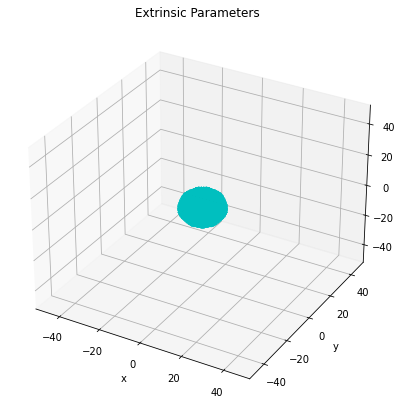

In [13]:
path = r"Datasets\3d\100x100_BP1.51\0\data.npz"

images, poses, focal = loadData(path)
visualizer = CameraPoseVisualizer([-50, 50], [-50, 50], [-50, 50])

for pose in poses:
    
    visualizer.extrinsic2pyramid(pose, 'c', 10)
visualizer.show()  

(106, 100, 100, 3)
(106, 4, 4)
initialize camera pose visualizer


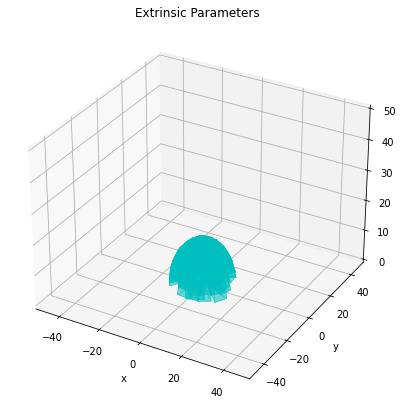

In [11]:
path = r"tiny_nerf_data.npz"

images, poses, focal = loadData(path)
visualizer = CameraPoseVisualizer([-50, 50], [-50, 50], [0, 50])

for pose in poses:
    visualizer.extrinsic2pyramid(pose, 'c', 10)
visualizer.show()  